## 1. Data Management
- Gathering data
- Data preprocessing
- Cleaning
- Metadata extraction
- Exploratory data analysis

In [423]:
# Add Python libraries here.
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

### 1-1. Read data files.
- According to the data description, the author uses 'NA' for 'No basement', 'No fireplace' and etc.
- If 'keep_default_na=False', and na_values are not specified, no strings will be parsed as NaN.
- Replace 'NA' to 'No'
- Manually search for possible other forms of missing values.

In [424]:
# Read the data files.
# According to the data description, the author uses 'NA' for 'No basement', 'No fireplace' and etc.
# If keep_default_na is False, and na_values are not specified, no strings will be parsed as NaN.
train_df = pd.read_csv("train.csv", keep_default_na=False)
test_df = pd.read_csv("test.csv", keep_default_na=False)

In [425]:
# It turns out every row has one or more missing values. Can't use train_df.dropna() funciton.
train_df = train_df.replace('NA','No')

In [426]:
# See if other types of missing values in the training set.
train_df.loc[train_df[col].isin(['', '#N/A','#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', 
                                 '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 
                                 'NULL', 'NaN', 'n/a', 'nan', 'null'])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


### 1-2. Correlation Matrix
- Assume the linear relationship between the features and outpus.
- Use the correaltion 0.5 as threshold to reduce dimension of the data set.

In [427]:
# Correlation matrix.
corrmat = train_df.corr()

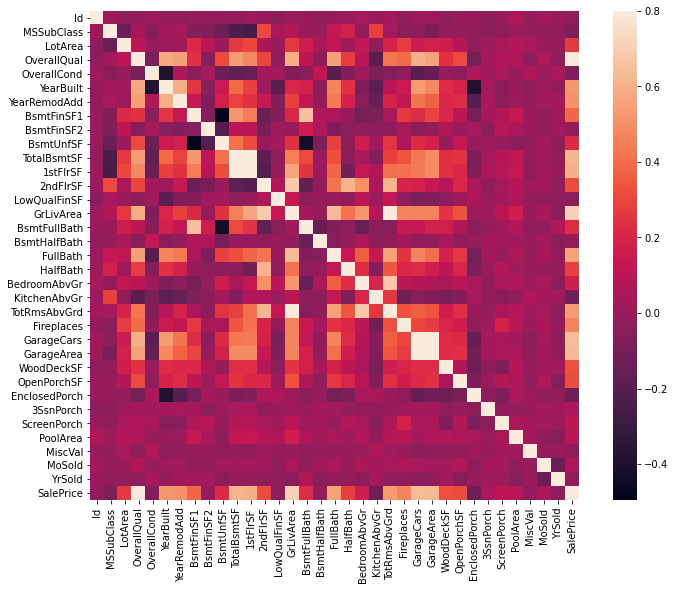

In [428]:
# Plot the correlation matrix.
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [429]:
#Find out which paramters appear to have an appreciable linear relationship with SalePrice
print("List of parameters that have a good linear model fit to Sale Price")
for i in range(len(corrmat["SalePrice"])-1):
    #Likely to be a linear relationship
    if((corrmat["SalePrice"][i] > 0.5 or corrmat["SalePrice"][i] < -0.5)):
        print(corrmat.columns[i], corrmat["SalePrice"][i])

List of parameters that have a good linear model fit to Sale Price
OverallQual 0.7909816005838047
YearBuilt 0.5228973328794967
YearRemodAdd 0.5071009671113867
TotalBsmtSF 0.6135805515591944
1stFlrSF 0.6058521846919166
GrLivArea 0.7086244776126511
FullBath 0.5606637627484452
TotRmsAbvGrd 0.5337231555820238
GarageCars 0.640409197258349
GarageArea 0.6234314389183598


In [430]:
#We are going to want data parameters to have a significant amount of data for proper training
#Thus, Alley, PoolQC, Fence, MiscFeature all should be removed for low values
#FireplaceQu also only has half total data, possible need for removal as well
##ID column merely shows the row number of each sample
#Has no relationship with sale price so can also remove
train_df = train_df.drop(["Id","Alley","PoolQC","Fence","MiscFeature"],axis=1)

### 1-3. Find outliers and remove them.
- Use scatter plots with the 3 highly correlated features vs Saleprice.
- GrLivArea vs SalePrice: There are some outliers at bottom-right.
- GarageCars vs SalesPrice: Unidentifiable
- GarageArea vs SalePrice: There are some outliers at bottom-right and top-mid.

In [431]:
# GrLivArea, GarageCars, and GarageArea columns have relatively large correlation with the SalePrice.
# Use scatterplots to detect the outliers.
def visualDetectionOutlier(train_df):
    sp = train_df['SalePrice']
    fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(6,12))
    axes[0].scatter(x=train_df['GrLivArea'],y=sp, alpha=0.5)
    axes[0].set_title("GrLivArea vs SalePrice")
    axes[0].set_xlabel("sqft")
    axes[1].set_ylabel("Price")
    axes[1].scatter(x=train_df['GarageCars'],y=sp, alpha=0.5)
    axes[1].set_title("GarageCars vs SalePrice")
    axes[1].set_xlabel("number of cars")
    axes[1].set_ylabel("Price")
    axes[2].scatter(x=train_df['GarageArea'],y=sp, alpha=0.5)
    axes[2].set_title("GarageArea vs SalePrice")
    axes[2].set_xlabel("sqft")
    axes[2].set_ylabel("Price")
    fig.tight_layout()
    plt.show()

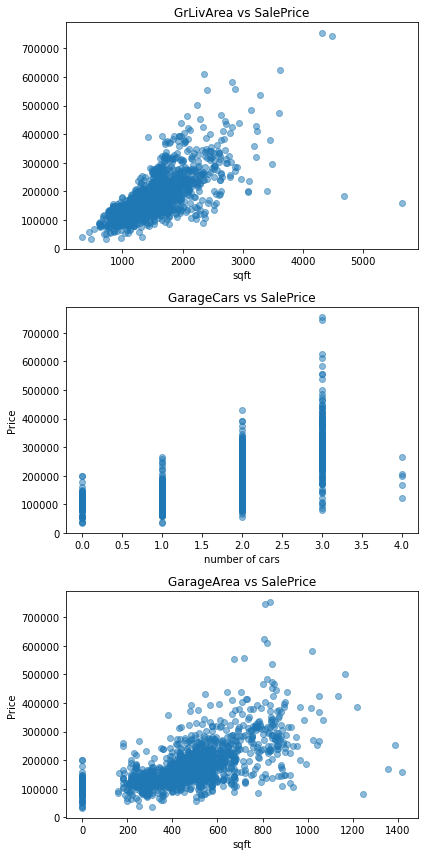

In [432]:
# Before removing outliers.
visualDetectionOutlier(train_df)

In [433]:
# Find the possible outliers in GrLivArea & SalePrice plot.
ol_plot1_bottomright = train_df.loc[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)]
ol_plot1_bottomright

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750
1298,60,RL,313,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000


In [434]:
ol_plot2_bottomright = train_df.loc[((train_df['GarageArea'] > 1200) & (train_df['SalePrice'] < 300000))]
ol_plot2_bottomright

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,20,RL,98,12704,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2009,New,Partial,253293
1061,30,C (all),120,18000,Grvl,Reg,Low,AllPub,Inside,Gtl,...,0,0,0,0,560,8,2008,ConLD,Normal,81000
1190,190,RL,No,32463,Pave,Reg,Low,AllPub,Inside,Mod,...,0,0,0,0,0,3,2007,WD,Normal,168000
1298,60,RL,313,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000


In [435]:
ol_plot2_topmiddle = train_df.loc[((train_df['GarageArea'] > 800) & (train_df['GarageArea'] < 1000)) & (train_df['SalePrice'] > 700000)]
ol_plot2_topmiddle

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,60,RL,104,21535,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2007,WD,Normal,755000
1182,60,RL,160,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,555,0,7,2007,WD,Abnorml,745000


In [436]:
# Remove the outliers.
train_df = train_df.drop(ol_plot1_bottomright.index.append(ol_plot2_bottomright.index).
                         append(ol_plot2_topmiddle.index))

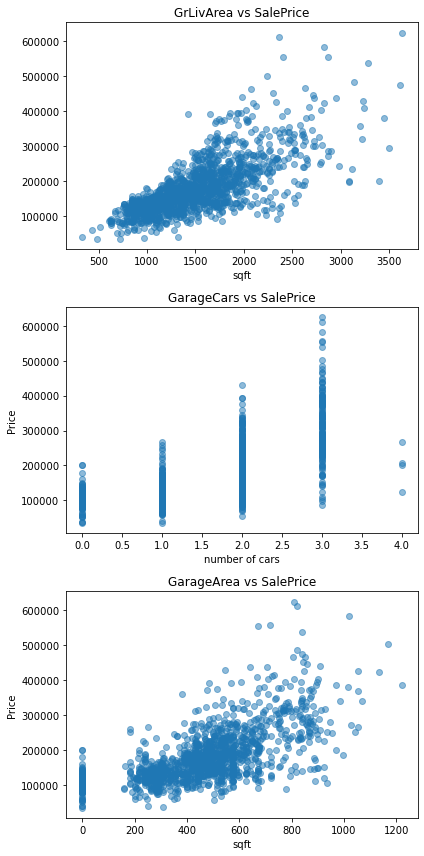

In [437]:
# Check out the linearity again.
visualDetectionOutlier(train_df)

### 1-3. Data normalization, 

In [271]:
#NA values in number valued columns can be replaced by 0 to retain only numbers
# for i in train_df.columns:
#     if (train_df[i].dtype == 'int64' or train_df[i].dtype == 'float64'):
#         train_df[i] = train_df[i].fillna(train_df[i].mode()[0])

## 2. Machine Learning and Algorithms
- Executing and developing all aspects of machine learning
- Developing a machine learning model from feature engineering all the way prediciton model
- Active learning

## 3. UI/UX and Data Visualization
- EDA
- Data understanding